### Using data augumentation to increase the training data

Even for MNIST digit data set that contain 60,000 images of training data, it is NOT large enough to account for many different ways people could write the digits.

Furthermore, some people may write the digits smaller or bigger than the images in the training set.  Sometimes they slant the writing or place them not in the center.

Most common way - when you don't have enough image data - is to 'virtually' generate training data from an existing set.

The term used is "augmentation".  It's a fancy way of saying "generate slightly modified images" of the original

#### Here is an example of generating "modified" images
pre-requisite modules are:
pillow, matplotlib


In [1]:
import numpy as np

# if using tensorflow, uncomment below. I am using plaidml as the keras backend on this machine
#from tensorflow import keras

from matplotlib import pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator,img_to_array, load_img

# this is the name of the dog file
dog_file_name = 'dog300.png'

# load the image
img = load_img(dog_file_name)
print('the image read in:', img)


Using plaidml.keras.backend backend.


the image read in: <PIL.PngImagePlugin.PngImageFile image mode=RGB size=300x300 at 0x2A117A84BA8>


In [2]:
# we need to change the image to numpy array for processing and normalize the value (0.0 to 1.0)
ar = (img_to_array(img).astype(float)) / 255.0

#show the shape 
print('array shape:', ar.shape)

array shape: (300, 300, 3)


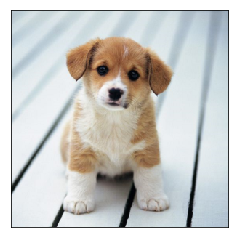

In [3]:
# display the image in matplotlib
%matplotlib inline
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(ar)
plt.show()
plt.close()


### Keras provides means to "modify" the image
We will use various parameters to rotate, zoom, translate the image
Look for the exact defintion of ImageDataGenerator at Keras documentation site: 
https://keras.io/preprocessing/image/


In [4]:
dog_datagen = ImageDataGenerator(
  rotation_range=45,
  width_shift_range=0.2,
  height_shift_range=0.2,
  zoom_range=0.3,
  horizontal_flip=True,
fill_mode='nearest')

# must convert the source a 4 tuple
ar4 = ar.reshape((1,) + ar.shape)
print('the shape of source image in 4-tuple:', ar4.shape)


the shape of source image in 4-tuple: (1, 300, 300, 3)


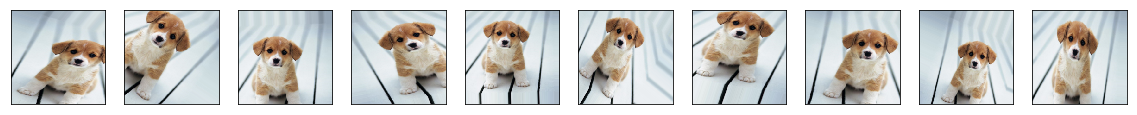

In [5]:
# let's generate 10 modified images

nimg = 10
images = []

i = 0
for generated_image in dog_datagen.flow(ar4 ):
    # drop the 1 in front so we have image that can be shown in matplotlib
    new_image = generated_image.reshape( 300,300,3)
    images.append(new_image)
    i +=1
    if( i >= nimg):
        break

#plot the images 
fig = plt.figure( figsize = (20,6))

for i in range(nimg):
    plt.subplot(1,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
plt.show()
plt.close()

### The images are transformed.
Using the same paradiam, we can generate "new" training data from existing 60,000 MNIST training set.  We may or may not get higher validation accuracy on the "test" data, but the model will be exposed to more exotic representation of digits and will recognize the hand-written digits better

### If we plan to use the same "data generator" into our MNIST CNN training model, the high level strategy is:
You read in a good trained model and leverage data augmentation on it (at least 100 or more epochs ) to force the model to recongize these "novel" training sets.

The core difference is that you are using "dynamically generated" images to train the model. In a real situation, you should train for over 100 epochs AT LEAST.

```python
fit_history2 = model.fit_generator(
  datagen.flow(x_train,y_train,batch_size=200),
  epochs = 15,
  validation_data = (x_test, y_test)
  #,callbacks=[cp_callback]
)
```

### I am going to leave it to the user to check how this model does against a model trained ONLY on the 60,000 data set, when you use this as the back engine for the UI


In [6]:
import os

'''
this is to generate a simple model to predict mnist 
it will use normal conv then use data aug on it
'''
########################################################
# load data
########################################################
mnist = keras.datasets.mnist
(x_train, y_train) , (x_test,y_test) = mnist.load_data()

# reshape to use conv
x_train = x_train.reshape( x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape( x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)

# convert class vectors to to_categorical class matrices
# example: 0 => [1,0,0,0,0,0,0,0,0] and 9 => [0,0,0,0,0,0,0,0,0,1]

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# convert the data from 0 to 1.0
x_train, x_test = x_train / 255.0, x_test / 255.0

########################################################
# load saved model or train
########################################################
model_file_name = 'saved_model.hdf5'
# if model exists, skip initial training and go to data augumentation 
if os.path.isfile(model_file_name):
  # read the model from the file
  model = keras.models.load_model(model_file_name)
else:
  # define the model and train: 
  model = keras.models.Sequential()
  model.add( keras.layers.Conv2D(32, kernel_size=(3,3), input_shape=input_shape , activation='relu' ))
  model.add( keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu' ))
  model.add( keras.layers.MaxPooling2D(pool_size=(2,2)))
  model.add( keras.layers.Dropout(rate=0.5))
  
  model.add( keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu' ))
  model.add( keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu' ))
  model.add( keras.layers.MaxPooling2D(pool_size=(2,2)))
  model.add( keras.layers.Dropout(rate=0.5))

  model.add( keras.layers.Flatten())
  model.add( keras.layers.Dense(265, activation='relu'))
  model.add( keras.layers.Dropout(rate=0.5))
  model.add( keras.layers.Dense(10, activation='softmax'))

  # compile to model
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  model.summary()

  #train the model with train data
  fit_history = model.fit(x_train, y_train,
    epochs=35 ,
    batch_size=200,
    validation_data=(x_test,y_test)
  )

  # save the model
  keras.models.save_model(model, model_file_name)
    
  ########################################################
  # save pic of loss + acc
  ########################################################
  
  fig = plt.figure()
  plt.plot(fit_history.history['loss'])
  plt.plot(fit_history.history['val_loss'])
  
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  fig.savefig('loss.png')
  plt.close()

  fig = plt.figure()
  plt.plot(fit_history.history['acc'])
  plt.plot(fit_history.history['val_acc'])
  
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  fig.savefig('accuracy.png')
  plt.close()

##### at this point, you have initial model trained on 60,000 original digits #####

# use datagen against it
datagen = keras.preprocessing.image.ImageDataGenerator(
  rotation_range = 45,
  width_shift_range=0.20,
  height_shift_range=0.20,
  zoom_range = 0.20
)

# this will generate few parameters to be used by data gen
datagen.fit(x_train)

# check point to save - on real system, I would save all
'''
checkpt_path='models/va{val_acc:.4f}-ac{acc:.4f}-vl{val_loss:.4f}-ep{epoch:03d}.hdf5'
cp_callback=keras.callbacks.ModelCheckpoint(
  checkpt_path,
  verbose=1
)
'''

# on real system, I would train the model for 100 to 2000 epoch since each epoch will expose
# the model to "new" set of digts. The validation accuracy may NOT improve, but the model will
# recognize more

fit_history2 = model.fit_generator(
  datagen.flow(x_train,y_train,batch_size=200),
  epochs = 15,
  validation_data = (x_test, y_test)
  #,callbacks=[cp_callback]
)

# show procession of training...
#https://github.com/sspak9/ml/blob/master/mac_plaid.ipynb
fig = plt.figure()
plt.plot(fit_history2.history['loss'])
plt.plot(fit_history2.history['val_loss'])
 
plt.title('model loss2')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
fig.savefig('loss2.png')
plt.close()

fig = plt.figure()
plt.plot(fit_history2.history['acc'])
plt.plot(fit_history2.history['val_acc'])
 
plt.title('model accuracy2')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
fig.savefig('accuracy2.png')
plt.close()

INFO:plaidml:Opening device "opencl_nvidia_quadro_p1000.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
__________

INFO:plaidml:Analyzing Ops: 125 of 362 operations complete
INFO:plaidml:Analyzing Ops: 131 of 362 operations complete


60000/60000 [==============================] - 33s 546us/step - loss: 0.4162 - acc: 0.8628 - val_loss: 0.0546 - val_acc: 0.9825
Epoch 2/35
60000/60000 [==============================] - 17s 287us/step - loss: 0.1109 - acc: 0.9662 - val_loss: 0.0344 - val_acc: 0.9883
Epoch 3/35
18400/60000 [========>.....................] - ETA: 11s - loss: 0.0842 - acc: 0.9742

KeyboardInterrupt: 